In [1]:
#!/usr/bin/env python
# coding: utf-8

import gym
import torch
import copy
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import random
import statistics
import time 

from torch import nn
from tqdm import tqdm
from scipy.optimize import minimize_scalar

In [2]:
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)  
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_dim)  

        # Apply the weights initialization
        self.apply(self.init_weights)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def init_weights(self, m):
        if type(m) == nn.Linear:
            init.xavier_normal_(m.weight)
            m.bias.data.fill_(0.01)

    def inject_parameters(self, pvec):
        new_state_dict = {}
        count = 0
        for name, param in self.named_parameters():
            sz = param.data.numel()
            raw = pvec[count:count + sz]
            reshaped = raw.reshape(param.data.shape)
            new_state_dict[name] = torch.from_numpy(reshaped).float()
            count += sz
        self.load_state_dict(new_state_dict)

In [3]:
def calculate_fitness(network, env, num_episodes):
    total_rewards = 0
    for _ in range(num_episodes):
        reward, _ = run_episode(network, env)
        total_rewards += reward
    avg_reward = total_rewards / num_episodes
    return avg_reward

def run_episode(network, env):
    state = env.reset()
    total_reward = 0.0
    done = False
    while not done:
        action = torch.argmax(network(torch.from_numpy(state).float().unsqueeze(0))).item()
        state, reward, done, _ = env.step(action)
        total_reward += reward
    return total_reward, _

def select_survivors(population, fitnesses, ELITISM):
    sorted_population = [x for _, x in sorted(zip(fitnesses, population), key=lambda pair: pair[0], reverse=True)]
    return sorted_population[:ELITISM]

def tournament_selection(population, fitnesses, tournament_size):
    selected_indices = np.random.randint(len(population), size=tournament_size)
    selected_fitnesses = [fitnesses[i] for i in selected_indices]
    winner_index = selected_indices[np.argmax(selected_fitnesses)]
    return population[winner_index]

def perturb_parameters(network, weight_clip, n_episodes):
    for episode in range(n_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        current_output = None

        while not done:
            if episode == 0 and current_output is None:
                prev_output = torch.Tensor([0.25, 0.25, 0.25, 0.25])
            else:
                prev_output = current_output.detach()

            current_param = torch.cat([param.view(-1) for param in network.parameters()])

            delta = torch.randn_like(current_param)

            current_output = network(torch.from_numpy(state).float().unsqueeze(0))

            error = ((current_output - prev_output)**2).mean()

            network.zero_grad()

            error.backward()

            gradient = torch.cat([param.grad.view(-1) for param in network.parameters()])

            gradient /= ((gradient**2).sum() + 1e-10)

            perturbation = np.clip(delta * gradient, -weight_clip, weight_clip)
            new_param = current_param + perturbation

            network.inject_parameters(new_param.detach().numpy())

            action = torch.argmax(network(torch.from_numpy(state).float().unsqueeze(0))).item()
            state, reward, done, _ = env.step(action)

In [4]:
# Constants
POPULATION_SIZE = 200 
GENERATIONS = 150
ELITISM = int(POPULATION_SIZE * 0.4)
TOURNAMENT_SIZE = 5
WEIGHT_CLIP = 0.5
INPUT_DIM = 8  # For LunarLander environment
OUTPUT_DIM = 4  # For LunarLander environment
MAX_EP = 1

FITNESS_HISTORY = list()
FITNESS_STDERROR_HISTORY = list()

env = gym.make("LunarLander-v2")

population = [PolicyNetwork(INPUT_DIM, OUTPUT_DIM) for _ in range(POPULATION_SIZE)]

/Users/jinhyunpark/miniforge3/envs/tilda/lib/python3.11/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/jinhyunpark/miniforge3/envs/tilda/lib/python3.11/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [5]:
start_time = time.time()

In [6]:
for generation in range(GENERATIONS):
    print(f"[Generation {generation}]")
    fitnesses = [calculate_fitness(network, env, MAX_EP) for network in tqdm(population)]
    avg_fitness = np.average(fitnesses)
    max_fitness = np.max(fitnesses)
    min_fitness = np.min(fitnesses)
    FITNESS_HISTORY.append([avg_fitness, max_fitness, min_fitness])
    standard_deviation = statistics.stdev(fitnesses)
    standard_error = standard_deviation / (POPULATION_SIZE ** 0.5)
    FITNESS_STDERROR_HISTORY.append(standard_error)
    print(f"Average Fitness: {avg_fitness} \n Best Fitness: {max_fitness} \n Worst Fitness: {min_fitness} \n Standard Error: {standard_error}")

    survivors = select_survivors(population, fitnesses, ELITISM)

    next_population = survivors  

    for _ in tqdm(range(POPULATION_SIZE - len(survivors))):
        parent = tournament_selection(population, fitnesses, TOURNAMENT_SIZE)
        offspring = copy.deepcopy(parent)
        perturb_parameters(offspring, WEIGHT_CLIP, MAX_EP)
        next_population.append(offspring)

    population = next_population

[Generation 0]


  0%|                                                                                                                                                          | 0/200 [00:00<?, ?it/s]/Users/jinhyunpark/miniforge3/envs/tilda/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 104.96it/s]


Average Fitness: -498.83917382319845 
 Best Fitness: -17.636770956064353 
 Worst Fitness: -2796.893327639029 
 Standard Error: 24.9577968192533


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:03<00:00, 30.57it/s]


[Generation 1]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 108.82it/s]


Average Fitness: -447.4678982863285 
 Best Fitness: 44.43221109625097 
 Worst Fitness: -3574.6968977188462 
 Standard Error: 29.448314572432263


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:03<00:00, 31.03it/s]


[Generation 2]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 138.65it/s]


Average Fitness: -354.50395028078776 
 Best Fitness: 13.277867948175498 
 Worst Fitness: -2907.2929291610108 
 Standard Error: 22.25766015710432


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:03<00:00, 31.15it/s]


[Generation 3]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 142.17it/s]


Average Fitness: -297.9480583243609 
 Best Fitness: 27.479240340150767 
 Worst Fitness: -4957.870586441814 
 Standard Error: 28.83903188106516


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:03<00:00, 34.08it/s]


[Generation 4]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 154.73it/s]


Average Fitness: -276.82398039254093 
 Best Fitness: 43.63019925646324 
 Worst Fitness: -1812.3302629324148 
 Standard Error: 20.59350903104259


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:03<00:00, 33.58it/s]


[Generation 5]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 156.39it/s]


Average Fitness: -255.10252958226323 
 Best Fitness: 18.16137998347645 
 Worst Fitness: -3920.886640361681 
 Standard Error: 26.60828767194508


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:03<00:00, 35.92it/s]


[Generation 6]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 199.50it/s]


Average Fitness: -196.27453534557856 
 Best Fitness: 21.223972972873398 
 Worst Fitness: -1182.1469673049428 
 Standard Error: 12.329019916279229


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:03<00:00, 37.26it/s]


[Generation 7]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 184.79it/s]


Average Fitness: -177.95813047541145 
 Best Fitness: 23.665122941884732 
 Worst Fitness: -1658.501961622073 
 Standard Error: 12.53459821661848


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:03<00:00, 34.78it/s]


[Generation 8]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 177.21it/s]


Average Fitness: -195.76307733989225 
 Best Fitness: 41.119059510381476 
 Worst Fitness: -1993.9375156452684 
 Standard Error: 15.74910770409473


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:03<00:00, 35.87it/s]


[Generation 9]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 191.00it/s]


Average Fitness: -177.33029078279404 
 Best Fitness: 60.16205994991731 
 Worst Fitness: -1743.325800161061 
 Standard Error: 11.911611909558765


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:03<00:00, 37.34it/s]


[Generation 10]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 178.93it/s]


Average Fitness: -162.1403987412933 
 Best Fitness: 247.95226553613065 
 Worst Fitness: -1206.0441356839349 
 Standard Error: 10.99710610541513


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:03<00:00, 37.66it/s]


[Generation 11]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 183.74it/s]


Average Fitness: -138.99493107915424 
 Best Fitness: 23.414817323600815 
 Worst Fitness: -769.3425381020093 
 Standard Error: 7.724074803226061


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:03<00:00, 37.12it/s]


[Generation 12]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 191.27it/s]


Average Fitness: -145.18063347455293 
 Best Fitness: 60.42774008079908 
 Worst Fitness: -1120.4921762455829 
 Standard Error: 8.736125311025415


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:03<00:00, 35.38it/s]


[Generation 13]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 185.66it/s]


Average Fitness: -154.0701775341682 
 Best Fitness: 73.9649747476868 
 Worst Fitness: -983.6976282373761 
 Standard Error: 9.645300991121836


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:03<00:00, 34.93it/s]


[Generation 14]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 172.78it/s]


Average Fitness: -119.0719799573172 
 Best Fitness: 252.1822370362451 
 Worst Fitness: -630.1121167522082 
 Standard Error: 7.521736618609019


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:03<00:00, 34.61it/s]


[Generation 15]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 141.83it/s]


Average Fitness: -129.422541937532 
 Best Fitness: 247.1589779370043 
 Worst Fitness: -506.8125066241149 
 Standard Error: 6.8869535681840315


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:03<00:00, 33.54it/s]


[Generation 16]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 183.09it/s]


Average Fitness: -135.90236207385396 
 Best Fitness: 56.32481434074887 
 Worst Fitness: -688.8516940665731 
 Standard Error: 7.845570838839428


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:03<00:00, 31.45it/s]


[Generation 17]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 178.07it/s]


Average Fitness: -139.80828188099508 
 Best Fitness: 293.2609447398877 
 Worst Fitness: -831.7379125413601 
 Standard Error: 9.60893310008438


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:03<00:00, 32.71it/s]


[Generation 18]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 167.54it/s]


Average Fitness: -129.68915122484174 
 Best Fitness: 264.5824737589508 
 Worst Fitness: -645.1071397537268 
 Standard Error: 8.375015231993794


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:03<00:00, 34.89it/s]


[Generation 19]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 164.51it/s]


Average Fitness: -136.75458613668525 
 Best Fitness: 208.41482665570297 
 Worst Fitness: -697.1865907266105 
 Standard Error: 7.81850545741419


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:04<00:00, 29.86it/s]


[Generation 20]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 109.08it/s]


Average Fitness: -102.02536647161469 
 Best Fitness: 261.16669374618596 
 Worst Fitness: -506.072792503986 
 Standard Error: 7.137003339556221


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:03<00:00, 30.53it/s]


[Generation 21]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 145.05it/s]


Average Fitness: -133.29188088744573 
 Best Fitness: 274.95609668982 
 Worst Fitness: -614.346987395734 
 Standard Error: 8.562718824599054


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:03<00:00, 31.04it/s]


[Generation 22]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 140.50it/s]


Average Fitness: -121.02408567084926 
 Best Fitness: 243.30932026954633 
 Worst Fitness: -704.3640563723758 
 Standard Error: 8.27098121386079


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:04<00:00, 29.89it/s]


[Generation 23]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 143.89it/s]


Average Fitness: -129.8099177502709 
 Best Fitness: 244.47847106178034 
 Worst Fitness: -653.4524786379748 
 Standard Error: 8.29585480719791


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:03<00:00, 32.25it/s]


[Generation 24]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 109.86it/s]


Average Fitness: -116.91381263833864 
 Best Fitness: 46.114741470114495 
 Worst Fitness: -529.0754147465195 
 Standard Error: 7.4439002532882474


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:03<00:00, 31.31it/s]


[Generation 25]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 150.96it/s]


Average Fitness: -119.37461882556501 
 Best Fitness: 173.79885001008307 
 Worst Fitness: -495.5212846042777 
 Standard Error: 8.305885211977404


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:03<00:00, 31.98it/s]


[Generation 26]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 151.83it/s]


Average Fitness: -135.5448674222182 
 Best Fitness: 43.045682234404325 
 Worst Fitness: -551.7715954455026 
 Standard Error: 8.901373314640013


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:04<00:00, 29.96it/s]


[Generation 27]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 142.21it/s]


Average Fitness: -119.08050167048339 
 Best Fitness: 255.63001391135418 
 Worst Fitness: -679.449966139279 
 Standard Error: 8.067082077950467


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:03<00:00, 30.50it/s]


[Generation 28]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 125.21it/s]


Average Fitness: -121.54169892363942 
 Best Fitness: 292.88673174833684 
 Worst Fitness: -563.5563264023879 
 Standard Error: 8.834552936690732


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:04<00:00, 26.06it/s]


[Generation 29]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 144.41it/s]


Average Fitness: -128.113950832862 
 Best Fitness: 283.0739610226019 
 Worst Fitness: -720.8487423579073 
 Standard Error: 9.611953940731569


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:04<00:00, 29.95it/s]


[Generation 30]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 139.37it/s]


Average Fitness: -126.23227067427102 
 Best Fitness: 285.65011959169505 
 Worst Fitness: -687.0182720550387 
 Standard Error: 10.47753347649204


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:04<00:00, 29.86it/s]


[Generation 31]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 139.45it/s]


Average Fitness: -113.1405353111327 
 Best Fitness: 203.9242889420965 
 Worst Fitness: -536.2437749771636 
 Standard Error: 7.8865593772595615


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:04<00:00, 27.93it/s]


[Generation 32]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 92.96it/s]


Average Fitness: -111.44607711289122 
 Best Fitness: 250.14576948484805 
 Worst Fitness: -438.95661721422533 
 Standard Error: 7.552393369628137


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:04<00:00, 29.58it/s]


[Generation 33]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 81.87it/s]


Average Fitness: -127.58442970076041 
 Best Fitness: 45.989006554358525 
 Worst Fitness: -628.3744492181125 
 Standard Error: 8.109673812058736


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:03<00:00, 30.82it/s]


[Generation 34]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 104.91it/s]


Average Fitness: -105.94781165759142 
 Best Fitness: 199.19064778238055 
 Worst Fitness: -472.00740569795573 
 Standard Error: 6.773577555281787


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:04<00:00, 25.82it/s]


[Generation 35]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 146.53it/s]


Average Fitness: -113.86607856035349 
 Best Fitness: 189.29282099854748 
 Worst Fitness: -647.17010547734 
 Standard Error: 8.624489251251251


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:03<00:00, 30.11it/s]


[Generation 36]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 146.11it/s]


Average Fitness: -112.0398151425975 
 Best Fitness: 269.59866507861864 
 Worst Fitness: -691.0044553001886 
 Standard Error: 8.698541229548551


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:03<00:00, 30.73it/s]


[Generation 37]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 142.57it/s]


Average Fitness: -118.3838275421917 
 Best Fitness: 209.20956878285156 
 Worst Fitness: -694.3860905092846 
 Standard Error: 8.257568776542966


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:03<00:00, 30.63it/s]


[Generation 38]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 126.41it/s]


Average Fitness: -108.52677891751165 
 Best Fitness: 218.12942440177113 
 Worst Fitness: -529.7576801654503 
 Standard Error: 8.112341754150203


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:03<00:00, 30.05it/s]


[Generation 39]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 149.73it/s]


Average Fitness: -111.95433242794687 
 Best Fitness: 269.51656376704847 
 Worst Fitness: -634.0061357741657 
 Standard Error: 8.847478222629487


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:04<00:00, 26.33it/s]


[Generation 40]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 142.95it/s]


Average Fitness: -111.39437481054273 
 Best Fitness: 247.69390343757942 
 Worst Fitness: -548.2853120620359 
 Standard Error: 8.183317204767242


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:04<00:00, 26.37it/s]


[Generation 41]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 81.05it/s]


Average Fitness: -119.5643222598072 
 Best Fitness: 273.48745477990286 
 Worst Fitness: -682.5590108808711 
 Standard Error: 9.112758136005784


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:04<00:00, 24.64it/s]


[Generation 42]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 102.33it/s]


Average Fitness: -121.54092202518777 
 Best Fitness: 267.56293121393975 
 Worst Fitness: -646.3440393888914 
 Standard Error: 9.367546646479392


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:04<00:00, 26.09it/s]


[Generation 43]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 146.05it/s]


Average Fitness: -127.59866726501586 
 Best Fitness: 264.7713202025624 
 Worst Fitness: -960.2689132787351 
 Standard Error: 9.269236140774863


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:04<00:00, 28.12it/s]


[Generation 44]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 137.02it/s]


Average Fitness: -103.53093780887166 
 Best Fitness: 244.37988970416973 
 Worst Fitness: -621.8233802015528 
 Standard Error: 8.010597013902157


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:04<00:00, 27.10it/s]


[Generation 45]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 142.58it/s]


Average Fitness: -103.14449903213321 
 Best Fitness: 283.6664270242097 
 Worst Fitness: -556.1646777770675 
 Standard Error: 7.637199699434299


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:04<00:00, 25.03it/s]


[Generation 46]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 125.92it/s]


Average Fitness: -100.85436339159452 
 Best Fitness: 248.0897255382833 
 Worst Fitness: -510.5612154829416 
 Standard Error: 7.449698978671851


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:04<00:00, 24.74it/s]


[Generation 47]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 122.34it/s]


Average Fitness: -99.55467529481946 
 Best Fitness: 255.10566183911968 
 Worst Fitness: -404.30440560870693 
 Standard Error: 8.055769888250476


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:04<00:00, 26.43it/s]


[Generation 48]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 111.26it/s]


Average Fitness: -98.43480391679013 
 Best Fitness: 203.9580190020359 
 Worst Fitness: -539.824820075326 
 Standard Error: 7.985417781674906


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:04<00:00, 27.75it/s]


[Generation 49]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 135.03it/s]


Average Fitness: -101.1626711178871 
 Best Fitness: 252.37512621394586 
 Worst Fitness: -573.7477143372953 
 Standard Error: 8.598100229918638


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:04<00:00, 24.46it/s]


[Generation 50]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 101.56it/s]


Average Fitness: -109.69036260909928 
 Best Fitness: 251.82410277026267 
 Worst Fitness: -647.5242320427197 
 Standard Error: 9.631243516443138


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:04<00:00, 28.58it/s]


[Generation 51]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 104.87it/s]


Average Fitness: -109.00302341585501 
 Best Fitness: 214.33737469506897 
 Worst Fitness: -768.1758650649626 
 Standard Error: 9.164072216972759


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:04<00:00, 24.97it/s]


[Generation 52]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 117.65it/s]


Average Fitness: -107.01531608075116 
 Best Fitness: 261.26128815602743 
 Worst Fitness: -512.0140767442724 
 Standard Error: 9.350409228541901


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:05<00:00, 21.02it/s]


[Generation 53]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 117.69it/s]


Average Fitness: -104.22707243531522 
 Best Fitness: 254.5468218732999 
 Worst Fitness: -1138.2509096587416 
 Standard Error: 11.332450098668403


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:04<00:00, 27.96it/s]


[Generation 54]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 106.16it/s]


Average Fitness: -94.41051033498132 
 Best Fitness: 288.31192516338365 
 Worst Fitness: -545.1473075642459 
 Standard Error: 8.58510510331951


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:04<00:00, 26.71it/s]


[Generation 55]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 117.43it/s]


Average Fitness: -101.21537018488745 
 Best Fitness: 203.11390532671737 
 Worst Fitness: -601.8180472361951 
 Standard Error: 8.307586342769921


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:04<00:00, 24.73it/s]


[Generation 56]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 105.34it/s]


Average Fitness: -88.05686002869872 
 Best Fitness: 297.2356220504381 
 Worst Fitness: -611.6359783547731 
 Standard Error: 7.976136688640281


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:04<00:00, 24.90it/s]


[Generation 57]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 81.91it/s]


Average Fitness: -102.62579239707249 
 Best Fitness: 252.3272680193972 
 Worst Fitness: -679.1430654759234 
 Standard Error: 9.10375187749294


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:04<00:00, 27.26it/s]


[Generation 58]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 113.76it/s]


Average Fitness: -112.82793227788547 
 Best Fitness: 243.25874758663596 
 Worst Fitness: -555.5346554625573 
 Standard Error: 7.323633644077011


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:05<00:00, 23.67it/s]


[Generation 59]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 76.46it/s]


Average Fitness: -132.3658053617071 
 Best Fitness: 253.66695893218042 
 Worst Fitness: -705.1418176794043 
 Standard Error: 10.663757754095071


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:05<00:00, 23.44it/s]


[Generation 60]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 121.74it/s]


Average Fitness: -97.11896445560102 
 Best Fitness: 273.26420268245175 
 Worst Fitness: -437.9250247773802 
 Standard Error: 8.366061350913778


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:04<00:00, 26.88it/s]


[Generation 61]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 128.26it/s]


Average Fitness: -93.72018290188993 
 Best Fitness: 285.56166165493175 
 Worst Fitness: -513.4269799210042 
 Standard Error: 7.9168185281540335


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:04<00:00, 24.81it/s]


[Generation 62]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 117.46it/s]


Average Fitness: -105.88050086480122 
 Best Fitness: 278.333961944607 
 Worst Fitness: -592.9824104840302 
 Standard Error: 8.983548978060837


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:04<00:00, 27.61it/s]


[Generation 63]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 130.80it/s]


Average Fitness: -111.69871323910786 
 Best Fitness: 276.28054865576655 
 Worst Fitness: -544.7822734680243 
 Standard Error: 8.719142835118939


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:04<00:00, 26.42it/s]


[Generation 64]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 125.51it/s]


Average Fitness: -89.83387098175125 
 Best Fitness: 227.20080663898466 
 Worst Fitness: -604.2967987510509 
 Standard Error: 7.889458487225268


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:04<00:00, 25.48it/s]


[Generation 65]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 89.65it/s]


Average Fitness: -91.52708496110398 
 Best Fitness: 246.3139660446794 
 Worst Fitness: -455.62951286836187 
 Standard Error: 8.167211579477797


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:04<00:00, 26.91it/s]


[Generation 66]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 114.43it/s]


Average Fitness: -77.10308200214182 
 Best Fitness: 258.04037664006523 
 Worst Fitness: -621.6853314265105 
 Standard Error: 8.155941041572678


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:05<00:00, 23.91it/s]


[Generation 67]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 118.52it/s]


Average Fitness: -96.32995739891922 
 Best Fitness: 271.19847792164114 
 Worst Fitness: -600.173959788003 
 Standard Error: 9.857344046210063


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:04<00:00, 24.03it/s]


[Generation 68]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 124.59it/s]


Average Fitness: -95.10768710308243 
 Best Fitness: 235.92023689178478 
 Worst Fitness: -611.4016708510683 
 Standard Error: 8.06016287414127


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:05<00:00, 23.57it/s]


[Generation 69]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 108.46it/s]


Average Fitness: -89.23629109170264 
 Best Fitness: 261.66881807146444 
 Worst Fitness: -559.9414606188961 
 Standard Error: 8.849379027505824


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:04<00:00, 24.42it/s]


[Generation 70]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 103.88it/s]


Average Fitness: -83.10389371237137 
 Best Fitness: 258.5612949141008 
 Worst Fitness: -371.081767956578 
 Standard Error: 7.505372249209883


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:05<00:00, 20.43it/s]


[Generation 71]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 83.51it/s]


Average Fitness: -94.73873997096622 
 Best Fitness: 260.2005404545554 
 Worst Fitness: -725.2486774352053 
 Standard Error: 8.942766615963826


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:06<00:00, 18.20it/s]


[Generation 72]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 119.04it/s]


Average Fitness: -82.62385892389568 
 Best Fitness: 245.45334829619767 
 Worst Fitness: -408.74611308638583 
 Standard Error: 7.92396225156681


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:04<00:00, 24.07it/s]


[Generation 73]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 77.83it/s]


Average Fitness: -96.86473089228488 
 Best Fitness: 249.80572680413485 
 Worst Fitness: -653.8979236725612 
 Standard Error: 8.0432609908207


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:05<00:00, 20.12it/s]


[Generation 74]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 98.15it/s]


Average Fitness: -96.51803063886331 
 Best Fitness: 194.96757909329955 
 Worst Fitness: -490.1070515041314 
 Standard Error: 8.110525108398347


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:04<00:00, 25.75it/s]


[Generation 75]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 86.37it/s]


Average Fitness: -91.20614237909999 
 Best Fitness: 261.1841979869609 
 Worst Fitness: -444.20084203729397 
 Standard Error: 8.012383763676585


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:05<00:00, 21.38it/s]


[Generation 76]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 109.43it/s]


Average Fitness: -109.20323593642637 
 Best Fitness: 247.29767548938622 
 Worst Fitness: -527.8791159472803 
 Standard Error: 9.135286136246048


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:05<00:00, 22.89it/s]


[Generation 77]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 90.48it/s]


Average Fitness: -102.19675748213967 
 Best Fitness: 224.88285820059207 
 Worst Fitness: -575.5272702150648 
 Standard Error: 8.444238583226714


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:05<00:00, 21.02it/s]


[Generation 78]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 94.00it/s]


Average Fitness: -95.22202774039715 
 Best Fitness: 259.0004590351284 
 Worst Fitness: -498.9254220871921 
 Standard Error: 8.59274556673419


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:04<00:00, 24.07it/s]


[Generation 79]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 106.77it/s]


Average Fitness: -102.57823373083187 
 Best Fitness: 283.6488408726332 
 Worst Fitness: -495.7471741800299 
 Standard Error: 9.007677028304867


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:05<00:00, 21.98it/s]


[Generation 80]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 78.47it/s]


Average Fitness: -94.98538271495804 
 Best Fitness: 260.49434799823416 
 Worst Fitness: -519.8866239500703 
 Standard Error: 9.286427134368214


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:05<00:00, 20.27it/s]


[Generation 81]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 111.27it/s]


Average Fitness: -94.50512310312169 
 Best Fitness: 266.0977734350897 
 Worst Fitness: -557.5929827467264 
 Standard Error: 8.52197784788691


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:05<00:00, 21.31it/s]


[Generation 82]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 107.38it/s]


Average Fitness: -84.56315729632078 
 Best Fitness: 297.3181727702709 
 Worst Fitness: -534.6504864496544 
 Standard Error: 9.52960973282949


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:05<00:00, 21.41it/s]


[Generation 83]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 126.93it/s]


Average Fitness: -83.08790710874595 
 Best Fitness: 289.48348251583906 
 Worst Fitness: -600.7172220570684 
 Standard Error: 8.227390051488484


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:05<00:00, 22.57it/s]


[Generation 84]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 95.26it/s]


Average Fitness: -97.92815758689954 
 Best Fitness: 277.1651985858223 
 Worst Fitness: -612.5316840551848 
 Standard Error: 9.4855695012415


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:05<00:00, 20.37it/s]


[Generation 85]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 83.05it/s]


Average Fitness: -88.372665426686 
 Best Fitness: 269.58005737370434 
 Worst Fitness: -460.605523810751 
 Standard Error: 8.359112259836724


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:05<00:00, 21.16it/s]


[Generation 86]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 80.37it/s]


Average Fitness: -114.97506158495163 
 Best Fitness: 236.30362590220108 
 Worst Fitness: -667.1694654155993 
 Standard Error: 9.76269062898944


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:04<00:00, 25.48it/s]


[Generation 87]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 107.21it/s]


Average Fitness: -86.62659364107361 
 Best Fitness: 249.70065840766745 
 Worst Fitness: -450.1780284860664 
 Standard Error: 8.342988185253565


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:05<00:00, 20.60it/s]


[Generation 88]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 101.49it/s]


Average Fitness: -86.80095029599288 
 Best Fitness: 269.8004798876764 
 Worst Fitness: -504.1510396798901 
 Standard Error: 7.399811272593786


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:04<00:00, 26.59it/s]


[Generation 89]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 89.01it/s]


Average Fitness: -85.06338556101174 
 Best Fitness: 271.30111623529194 
 Worst Fitness: -383.74546405191484 
 Standard Error: 8.138415819535854


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:04<00:00, 27.34it/s]


[Generation 90]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 99.39it/s]


Average Fitness: -84.12236703790822 
 Best Fitness: 248.43735769388468 
 Worst Fitness: -450.32749530090734 
 Standard Error: 7.072993191725168


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:05<00:00, 21.00it/s]


[Generation 91]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 96.64it/s]


Average Fitness: -89.76167467123126 
 Best Fitness: 277.1914541217496 
 Worst Fitness: -354.27562016925924 
 Standard Error: 7.875458258568219


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:05<00:00, 23.86it/s]


[Generation 92]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 88.46it/s]


Average Fitness: -86.79490521980267 
 Best Fitness: 263.65866987142283 
 Worst Fitness: -537.4671741479235 
 Standard Error: 8.747097112890307


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:05<00:00, 22.93it/s]


[Generation 93]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 83.42it/s]


Average Fitness: -90.14382495812424 
 Best Fitness: 246.3885955309541 
 Worst Fitness: -537.2319839064824 
 Standard Error: 8.412186753559045


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:05<00:00, 20.66it/s]


[Generation 94]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 118.03it/s]


Average Fitness: -117.2841831280442 
 Best Fitness: 69.22655308419607 
 Worst Fitness: -1074.944061012559 
 Standard Error: 9.471540729400619


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:04<00:00, 25.05it/s]


[Generation 95]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 131.45it/s]


Average Fitness: -105.1226809400216 
 Best Fitness: 262.5976198170448 
 Worst Fitness: -406.5403495832451 
 Standard Error: 7.854094849455314


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:05<00:00, 21.03it/s]


[Generation 96]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 105.41it/s]


Average Fitness: -112.27686203084073 
 Best Fitness: 240.75609280749558 
 Worst Fitness: -606.7266508906166 
 Standard Error: 8.813008275109668


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:05<00:00, 22.50it/s]


[Generation 97]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 106.85it/s]


Average Fitness: -99.61194334573521 
 Best Fitness: 309.7672325842483 
 Worst Fitness: -478.23507336650806 
 Standard Error: 9.335234124209961


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:06<00:00, 18.88it/s]


[Generation 98]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 111.91it/s]


Average Fitness: -92.98767015456218 
 Best Fitness: 281.4446633587562 
 Worst Fitness: -497.364667822158 
 Standard Error: 8.54277967465984


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:05<00:00, 23.14it/s]


[Generation 99]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 117.78it/s]


Average Fitness: -105.04102756324104 
 Best Fitness: 279.222356006182 
 Worst Fitness: -624.3296560052423 
 Standard Error: 8.778489866837777


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:05<00:00, 21.93it/s]


[Generation 100]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 104.22it/s]


Average Fitness: -84.61642877261198 
 Best Fitness: 270.212300129935 
 Worst Fitness: -760.9242222291128 
 Standard Error: 9.446106973700905


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:04<00:00, 24.24it/s]


[Generation 101]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 115.32it/s]


Average Fitness: -102.02121310157312 
 Best Fitness: 275.69211837959864 
 Worst Fitness: -649.0572407149692 
 Standard Error: 9.220855948555053


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:05<00:00, 23.59it/s]


[Generation 102]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 81.91it/s]


Average Fitness: -104.2329693082416 
 Best Fitness: 292.03809509745696 
 Worst Fitness: -606.4128768783787 
 Standard Error: 9.14424948001956


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:05<00:00, 20.10it/s]


[Generation 103]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 82.79it/s]


Average Fitness: -108.99104403060886 
 Best Fitness: 284.74230107366725 
 Worst Fitness: -651.8283320257079 
 Standard Error: 10.708820496767418


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:05<00:00, 20.13it/s]


[Generation 104]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 79.39it/s]


Average Fitness: -123.42270993499973 
 Best Fitness: 284.3886518520842 
 Worst Fitness: -758.3655093566518 
 Standard Error: 11.373082555846114


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:06<00:00, 18.59it/s]


[Generation 105]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 128.17it/s]


Average Fitness: -100.07488768648105 
 Best Fitness: 268.129179214902 
 Worst Fitness: -941.1182956987069 
 Standard Error: 9.6831124173884


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:06<00:00, 17.95it/s]


[Generation 106]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 114.06it/s]


Average Fitness: -101.3738039565664 
 Best Fitness: 259.7373357206079 
 Worst Fitness: -546.5735945225981 
 Standard Error: 8.987587007339666


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:05<00:00, 20.43it/s]


[Generation 107]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 121.45it/s]


Average Fitness: -100.29641763813852 
 Best Fitness: 215.3111311136842 
 Worst Fitness: -650.2822392312106 
 Standard Error: 8.160131051403283


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:06<00:00, 19.40it/s]


[Generation 108]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 69.93it/s]


Average Fitness: -99.08989915936004 
 Best Fitness: 250.7677199644215 
 Worst Fitness: -647.8302591257304 
 Standard Error: 9.123136624906726


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:06<00:00, 17.92it/s]


[Generation 109]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 118.82it/s]


Average Fitness: -88.70185201632783 
 Best Fitness: 259.9057452000096 
 Worst Fitness: -431.8656106341712 
 Standard Error: 7.69771490426555


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:05<00:00, 21.65it/s]


[Generation 110]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 100.00it/s]


Average Fitness: -90.70961710984393 
 Best Fitness: 273.18624574622316 
 Worst Fitness: -504.22229230545787 
 Standard Error: 8.403943588221706


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:05<00:00, 22.38it/s]


[Generation 111]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 72.73it/s]


Average Fitness: -91.59347250909477 
 Best Fitness: 237.2336511646094 
 Worst Fitness: -509.2905757713072 
 Standard Error: 8.146704236910809


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:06<00:00, 19.71it/s]


[Generation 112]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 111.88it/s]


Average Fitness: -92.84699683420222 
 Best Fitness: 274.798482599629 
 Worst Fitness: -763.7029234974023 
 Standard Error: 9.19586737928734


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:07<00:00, 15.87it/s]


[Generation 113]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 76.20it/s]


Average Fitness: -90.13184514072043 
 Best Fitness: 280.80776453192146 
 Worst Fitness: -463.08114872795585 
 Standard Error: 8.97943080060804


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:05<00:00, 20.42it/s]


[Generation 114]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 99.44it/s]


Average Fitness: -82.28199433042799 
 Best Fitness: 292.05051397415275 
 Worst Fitness: -627.3248565079932 
 Standard Error: 9.451971049109465


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:08<00:00, 13.45it/s]


[Generation 115]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 82.59it/s]


Average Fitness: -105.02122913760715 
 Best Fitness: 282.030419942853 
 Worst Fitness: -888.8129617081279 
 Standard Error: 10.517107799858259


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:06<00:00, 17.90it/s]


[Generation 116]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 75.19it/s]


Average Fitness: -115.33889030572892 
 Best Fitness: 284.4207050926126 
 Worst Fitness: -497.73158645175937 
 Standard Error: 9.20485295878534


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:05<00:00, 20.90it/s]


[Generation 117]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 110.39it/s]


Average Fitness: -105.71722055202994 
 Best Fitness: 252.65284149941377 
 Worst Fitness: -550.3477652106719 
 Standard Error: 9.23917290909947


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:05<00:00, 21.38it/s]


[Generation 118]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 88.99it/s]


Average Fitness: -83.0671397612667 
 Best Fitness: 288.9849699734511 
 Worst Fitness: -380.6000774883222 
 Standard Error: 9.167019909445466


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:05<00:00, 20.93it/s]


[Generation 119]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 89.24it/s]


Average Fitness: -81.06871251866258 
 Best Fitness: 278.7690848758921 
 Worst Fitness: -381.6146081086076 
 Standard Error: 8.745372672761452


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:05<00:00, 20.62it/s]


[Generation 120]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 85.53it/s]


Average Fitness: -81.08432177067778 
 Best Fitness: 285.97540506743144 
 Worst Fitness: -549.5985514830712 
 Standard Error: 10.066145803612756


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:06<00:00, 18.19it/s]


[Generation 121]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 77.55it/s]


Average Fitness: -78.34284768436085 
 Best Fitness: 253.0687458030839 
 Worst Fitness: -668.4172742074851 
 Standard Error: 10.115163436523044


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:08<00:00, 14.52it/s]


[Generation 122]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 91.90it/s]


Average Fitness: -94.40412392621012 
 Best Fitness: 283.0931384214908 
 Worst Fitness: -493.31338734734874 
 Standard Error: 9.742915722683103


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:06<00:00, 17.40it/s]


[Generation 123]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 58.18it/s]


Average Fitness: -81.731652478464 
 Best Fitness: 276.58048263693877 
 Worst Fitness: -465.5077093054126 
 Standard Error: 9.958847285488673


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:06<00:00, 17.68it/s]


[Generation 124]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 88.23it/s]


Average Fitness: -94.82931097019103 
 Best Fitness: 267.3892461943186 
 Worst Fitness: -529.007196010208 
 Standard Error: 9.898307331263675


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:07<00:00, 16.19it/s]


[Generation 125]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 69.38it/s]


Average Fitness: -81.80940543619364 
 Best Fitness: 279.2522456666169 
 Worst Fitness: -668.7664573929943 
 Standard Error: 9.739967853143437


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:06<00:00, 18.21it/s]


[Generation 126]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 57.30it/s]


Average Fitness: -73.67808412683736 
 Best Fitness: 281.90757025783336 
 Worst Fitness: -450.710445473348 
 Standard Error: 10.120574292503466


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:08<00:00, 14.34it/s]


[Generation 127]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 59.30it/s]


Average Fitness: -97.11206408678197 
 Best Fitness: 268.1747939181521 
 Worst Fitness: -495.8581512053653 
 Standard Error: 9.097890314888025


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:08<00:00, 14.80it/s]


[Generation 128]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 62.56it/s]


Average Fitness: -83.3529495756135 
 Best Fitness: 267.42646070120713 
 Worst Fitness: -534.1802991130646 
 Standard Error: 9.623002118522734


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:08<00:00, 13.47it/s]


[Generation 129]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 83.95it/s]


Average Fitness: -89.66100840194238 
 Best Fitness: 277.3166022101133 
 Worst Fitness: -642.2714912716708 
 Standard Error: 9.650403074175832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:06<00:00, 18.50it/s]


[Generation 130]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 98.37it/s]


Average Fitness: -78.18956600479503 
 Best Fitness: 272.30274551711733 
 Worst Fitness: -823.3160950575071 
 Standard Error: 10.235230178700048


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:08<00:00, 14.58it/s]


[Generation 131]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 88.72it/s]


Average Fitness: -81.2224910242299 
 Best Fitness: 275.7523179473628 
 Worst Fitness: -541.163862972696 
 Standard Error: 9.589527487240648


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:08<00:00, 14.75it/s]


[Generation 132]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 76.59it/s]


Average Fitness: -81.64743230710454 
 Best Fitness: 245.97696511887037 
 Worst Fitness: -502.01399464000474 
 Standard Error: 10.263429007191199


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:07<00:00, 17.13it/s]


[Generation 133]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 86.94it/s]


Average Fitness: -76.93135422484997 
 Best Fitness: 270.2277630508978 
 Worst Fitness: -500.923308740948 
 Standard Error: 9.079444243764705


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:06<00:00, 18.10it/s]


[Generation 134]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 71.65it/s]


Average Fitness: -75.38080245684064 
 Best Fitness: 273.958868465806 
 Worst Fitness: -539.1108270643465 
 Standard Error: 8.934589145562628


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:07<00:00, 16.70it/s]


[Generation 135]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 73.68it/s]


Average Fitness: -84.48756971937186 
 Best Fitness: 278.0616724163232 
 Worst Fitness: -351.10348700543045 
 Standard Error: 7.801169842307113


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:07<00:00, 15.50it/s]


[Generation 136]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 80.94it/s]


Average Fitness: -80.89110857711569 
 Best Fitness: 293.18688398445977 
 Worst Fitness: -561.2292098794663 
 Standard Error: 8.893702734602497


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:07<00:00, 16.38it/s]


[Generation 137]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 100.89it/s]


Average Fitness: -87.04541104518395 
 Best Fitness: 231.05792127589635 
 Worst Fitness: -494.45070801673336 
 Standard Error: 8.831073186348323


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:06<00:00, 17.88it/s]


[Generation 138]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 73.96it/s]


Average Fitness: -61.39149505882185 
 Best Fitness: 272.4972288481775 
 Worst Fitness: -447.1647865205818 
 Standard Error: 8.699252806498697


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:06<00:00, 18.06it/s]


[Generation 139]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 74.28it/s]


Average Fitness: -53.19704752420162 
 Best Fitness: 252.5073336030158 
 Worst Fitness: -456.7592471503163 
 Standard Error: 7.6326633176704055


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:09<00:00, 13.13it/s]


[Generation 140]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 71.02it/s]


Average Fitness: -71.55202972638834 
 Best Fitness: 273.89584669024674 
 Worst Fitness: -617.2797806145508 
 Standard Error: 9.500028287567508


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:09<00:00, 12.78it/s]


[Generation 141]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 59.46it/s]


Average Fitness: -73.04578884080136 
 Best Fitness: 263.8005158025469 
 Worst Fitness: -464.87438999593655 
 Standard Error: 8.73751585177439


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:06<00:00, 17.29it/s]


[Generation 142]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 66.61it/s]


Average Fitness: -81.67329353000834 
 Best Fitness: 277.0489029409214 
 Worst Fitness: -576.3401099348893 
 Standard Error: 9.366815193081042


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:06<00:00, 17.70it/s]


[Generation 143]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 81.60it/s]


Average Fitness: -74.14266865147913 
 Best Fitness: 263.833754775387 
 Worst Fitness: -436.13530582536697 
 Standard Error: 8.593011704424642


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:06<00:00, 18.81it/s]


[Generation 144]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 72.19it/s]


Average Fitness: -73.87579309928121 
 Best Fitness: 285.63074602843915 
 Worst Fitness: -511.88620350379074 
 Standard Error: 9.216511919264994


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:08<00:00, 13.69it/s]


[Generation 145]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 73.25it/s]


Average Fitness: -81.86754172067651 
 Best Fitness: 295.52247862562035 
 Worst Fitness: -516.616143480925 
 Standard Error: 9.731865983705058


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:06<00:00, 18.63it/s]


[Generation 146]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 73.07it/s]


Average Fitness: -88.87897910232516 
 Best Fitness: 275.2671275308453 
 Worst Fitness: -470.7346008900397 
 Standard Error: 9.15005657881049


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:08<00:00, 14.99it/s]


[Generation 147]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 82.50it/s]


Average Fitness: -72.42409600403106 
 Best Fitness: 274.42433938619376 
 Worst Fitness: -605.5510905680433 
 Standard Error: 10.025964507061715


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:08<00:00, 14.68it/s]


[Generation 148]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 73.71it/s]


Average Fitness: -89.54123563781224 
 Best Fitness: 275.6355025514451 
 Worst Fitness: -567.6315563421432 
 Standard Error: 10.164051310794832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:08<00:00, 14.58it/s]


[Generation 149]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 88.49it/s]


Average Fitness: -82.0180600207926 
 Best Fitness: 282.2206208446655 
 Worst Fitness: -596.8887479094913 
 Standard Error: 10.174607768115326


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:07<00:00, 16.86it/s]


In [7]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 1098.312914133072 seconds ---


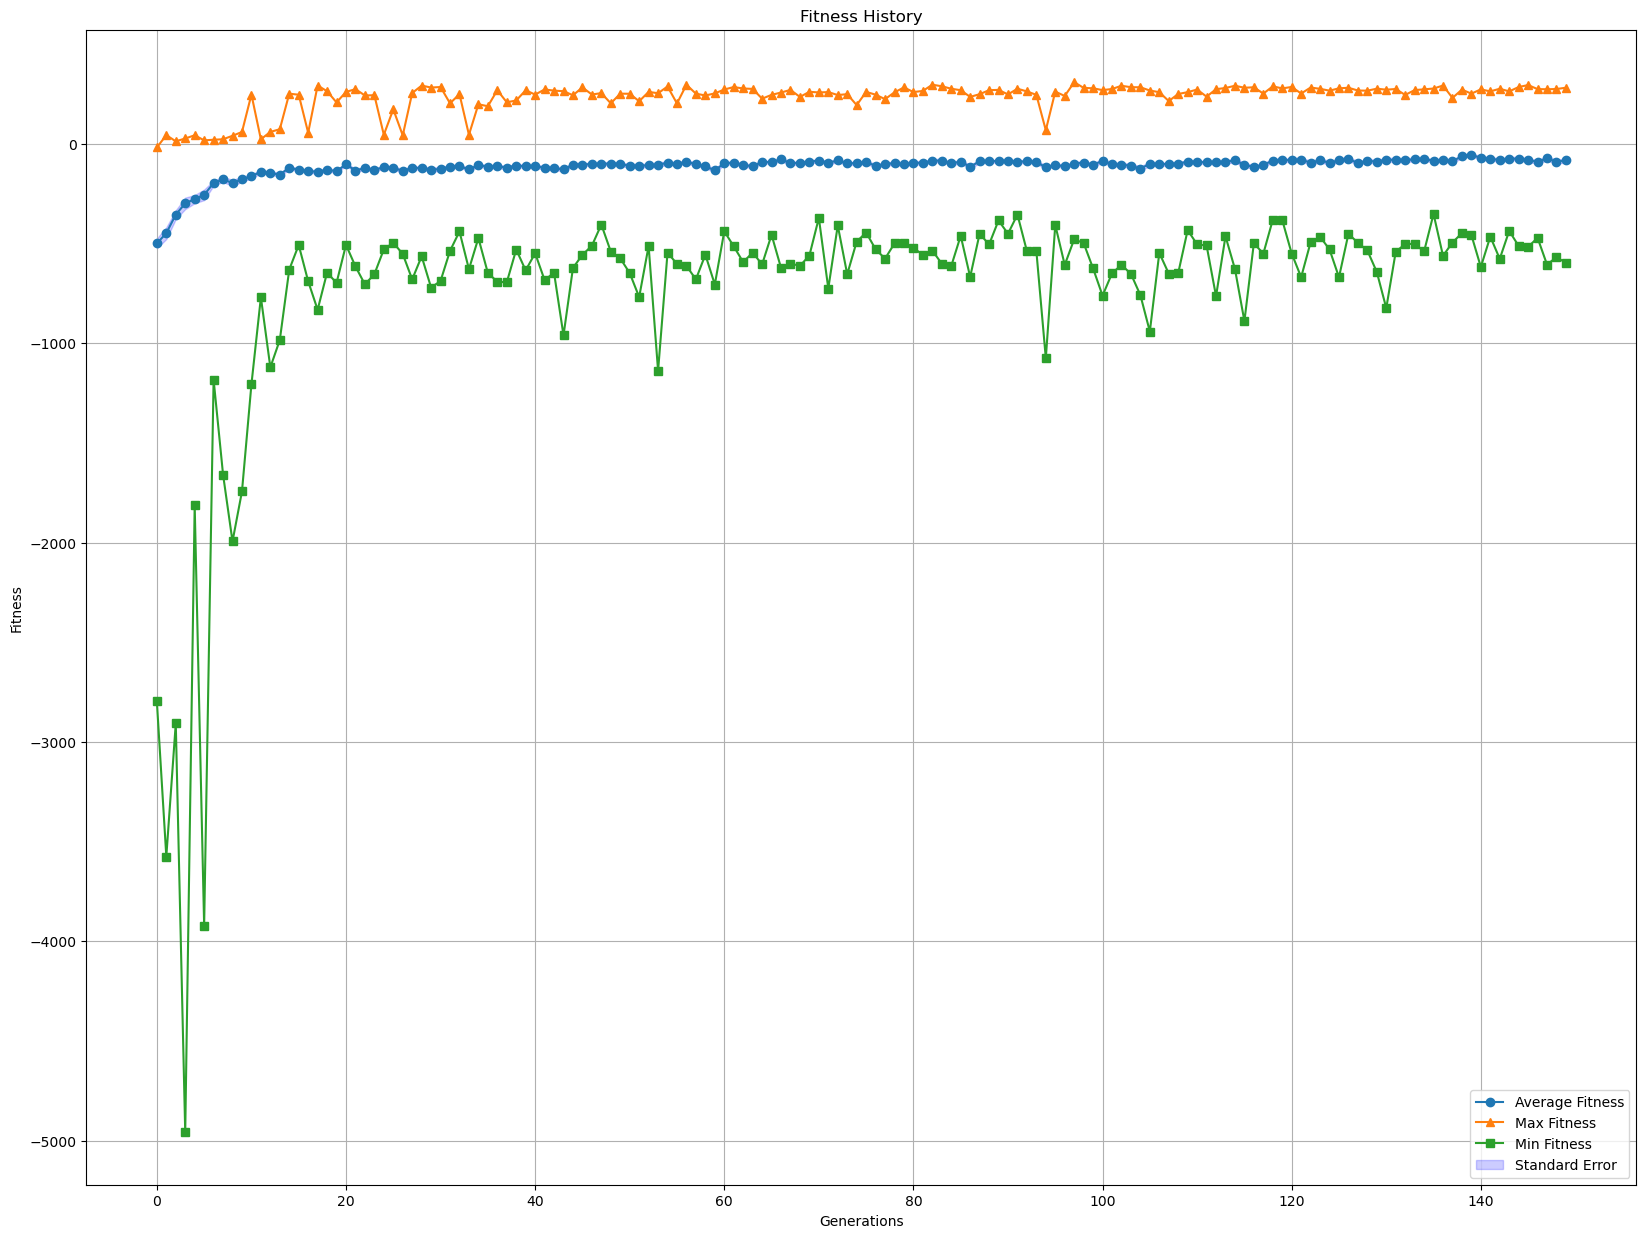

In [10]:
plt.figure(figsize=(20, 15))
plt.plot(np.arange(GENERATIONS), np.array(FITNESS_HISTORY)[:,0], marker='o', linestyle='-', label='Average Fitness')
plt.plot(np.arange(GENERATIONS), np.array(FITNESS_HISTORY)[:,1], marker='^', linestyle='-', label='Max Fitness')
plt.plot(np.arange(GENERATIONS), np.array(FITNESS_HISTORY)[:,2], marker='s', linestyle='-', label='Min Fitness')
plt.fill_between(np.arange(GENERATIONS), np.array(FITNESS_HISTORY)[:,0] - np.array(FITNESS_STDERROR_HISTORY), np.array(FITNESS_HISTORY)[:,0] + np.array(FITNESS_STDERROR_HISTORY),
                 alpha=0.2, color='blue', label='Standard Error')

plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.title('Fitness History')
plt.grid()
plt.legend()
plt.show()

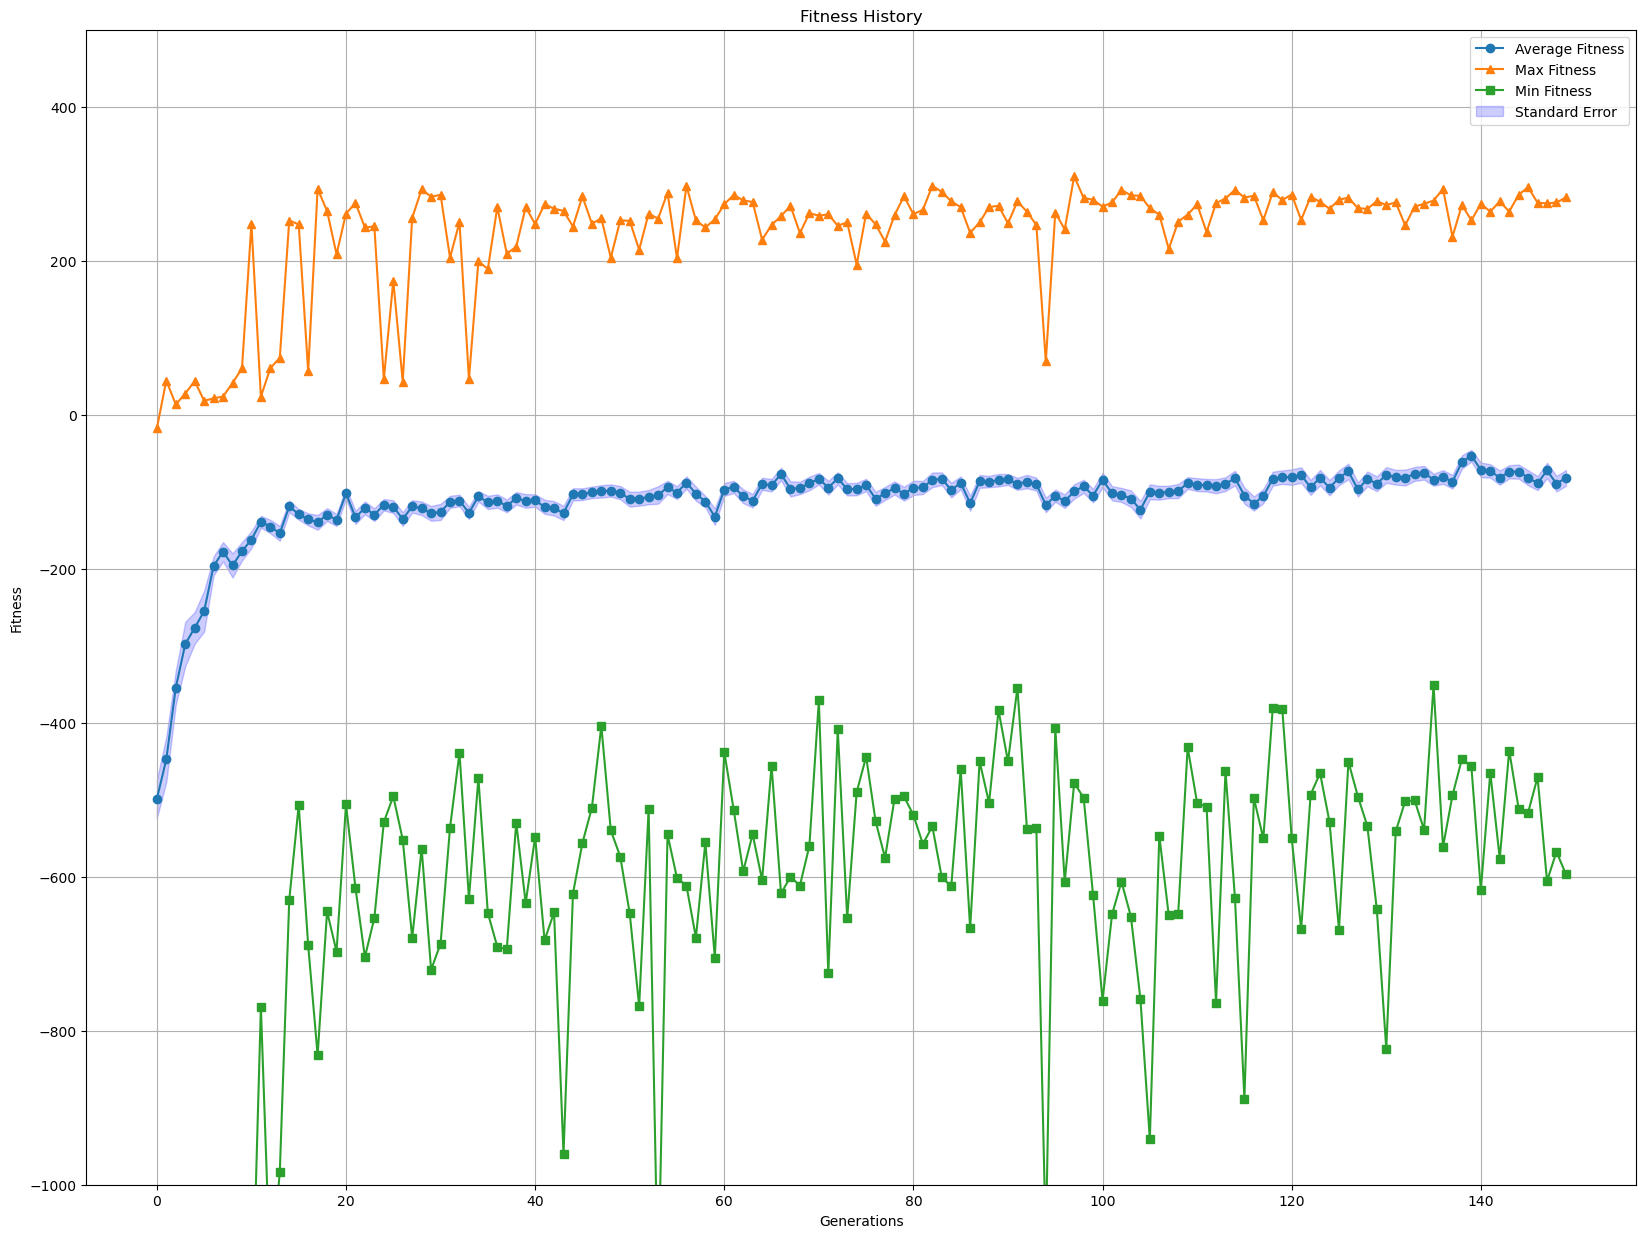

In [12]:
plt.figure(figsize=(20, 15))
plt.plot(np.arange(GENERATIONS), np.array(FITNESS_HISTORY)[:,0], marker='o', linestyle='-', label='Average Fitness')
plt.plot(np.arange(GENERATIONS), np.array(FITNESS_HISTORY)[:,1], marker='^', linestyle='-', label='Max Fitness')
plt.plot(np.arange(GENERATIONS), np.array(FITNESS_HISTORY)[:,2], marker='s', linestyle='-', label='Min Fitness')
plt.fill_between(np.arange(GENERATIONS), np.array(FITNESS_HISTORY)[:,0] - np.array(FITNESS_STDERROR_HISTORY), np.array(FITNESS_HISTORY)[:,0] + np.array(FITNESS_STDERROR_HISTORY),
                 alpha=0.2, color='blue', label='Standard Error')

plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.ylim([-1000, 500])
plt.title('Fitness History')
plt.grid()
plt.legend()
plt.show()